In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.special

# Exponential from uniform
- generate $10^6$ samples from $U(0, 10^3)$
- sort the list of sample values
- compute differences between consequent values $\Delta t_i \equiv t_{i+1} - t_i$
- plot $\Delta t$ distribution
- fit an exponential function to it and find $\lambda$

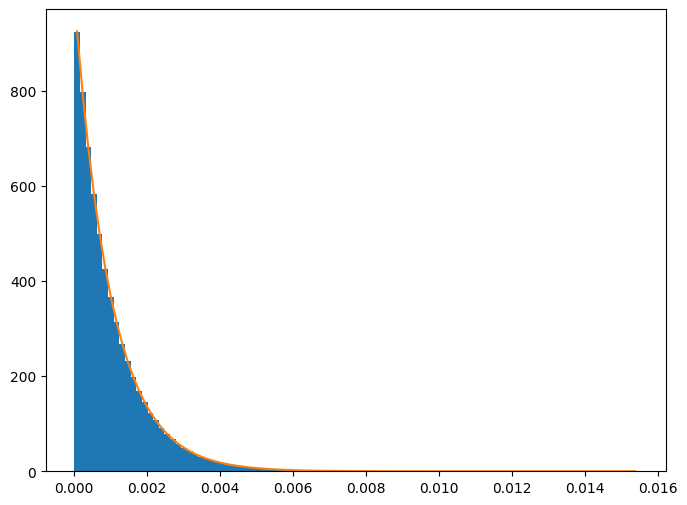

In [2]:
T = 1_000
UNIFORM_SAMPLE_SIZE = 1_000_000
times = np.random.uniform(0, T, size=UNIFORM_SAMPLE_SIZE)
times.sort()
deltas = times[1:] - times[:-1]

fig, ax = plt.subplots(figsize=(8, 6))
values, bin_edges, _ = ax.hist(deltas, bins=100, density=True)
bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
lambda_expected = UNIFORM_SAMPLE_SIZE / T
ax.plot(bin_centers, lambda_expected * np.exp(- lambda_expected * bin_centers))

plt.show()

# Constructing Poisson distribution numerically
- generate $n=10$ values of $t \sim U(0, \Delta t = 10^3)$ 
- compute $k$ — a number of events that happen in a much shorter interval $[0, \delta t \equiv p \Delta t]$, $p = 0.01$
- repeat $10^5$ times and populate sample for $k$
- plot the histogram, compare with binomial and poisson distributions
- repeat for $n = 10, 100, 1000$
- repeat for $p = 0.01, 0.05, 0.1, 0.5$

In [3]:
from typing import Iterable
import math


def log_factorial(n: int) -> int:
    return sum(np.log(i) for i in range(1, n + 1))


def binomial_probabilities(n: int, p: float, k: Iterable[int]) -> list[float]:
    res: list[float] = []
    for k_i in k:
        res.append(
            math.exp(
                log_factorial(n)
                - log_factorial(k_i)
                - log_factorial(n - k_i)
                + k_i * np.log(p)
                + (n - k_i) * np.log(1 - p)
            )
        )
    return res


def poisson_probabilities(nu: float, k: Iterable[int]) -> list[float]:
    res: list[float] = []
    for k_i in k:
        res.append(math.exp(k_i * np.log(nu) - nu - log_factorial(k_i)))
    return res

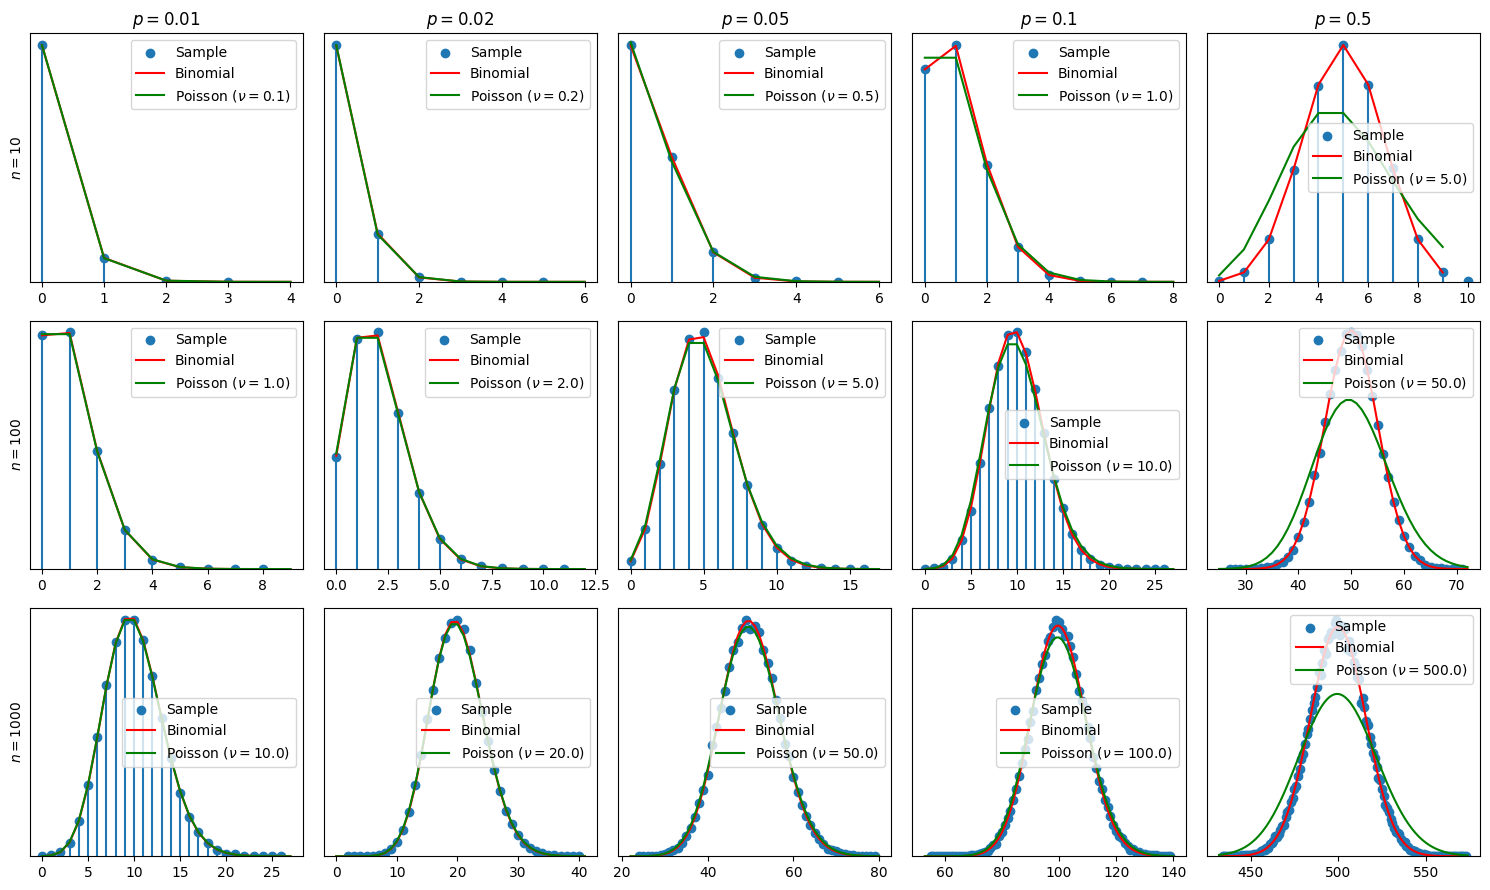

In [4]:
n_options = [10, 100, 1000]
p_options = [0.01, 0.02, 0.05, 0.1, 0.5]

T = 1000
sample_size = 100_000

fig, axes_matrix = plt.subplots(
    ncols=len(p_options),
    nrows=len(n_options),
    figsize=(
        3 * len(p_options),
        3 * len(n_options),
    ),
)

for n, axes_row in zip(n_options, axes_matrix):
    axes_row[0].set_ylabel(f"$n = {n}$")
    for p, ax in zip(p_options, axes_row):
        k_sample: list[int] = [
            np.count_nonzero(np.random.uniform(0, T, size=n) < p * T)
            for _ in range(sample_size)
        ]
        k_min = max(0, min(k_sample) - 2)
        k_max = min(n, max(k_sample) + 2)
        k_range = np.arange(k_min, k_max)

        bins = np.arange(min(k_sample), max(k_sample) + 2, dtype="int") - 0.5
        x_sample_hist, _ = np.histogram(k_sample, bins=bins, density=True)
        bin_cntr = bins[:-1] + 0.5
        ax.scatter(bin_cntr, x_sample_hist, label="Sample")
        if k_max - k_min < 30:
            ax.vlines(bin_cntr, 0, x_sample_hist)

        ax.set_ylim(bottom=0)
        ax.plot(
            k_range,
            binomial_probabilities(n, p, k_range),
            color="r",
            label=f"Binomial",
        )
        ax.plot(
            k_range,
            poisson_probabilities(n * p, k_range),
            color="g",
            label=f"Poisson ($\\nu = {n*p}$)",
        )
        ax.legend()
        ax.set_yticks([])
        if n == n_options[0]:
            ax.set_title(f"$p = {p} $")

plt.tight_layout()
plt.show()

# $\chi^2$ distribution generation
- generate $10^5$ sets of $n$ standard normal variables $y_i, i = 1...n$
- populate a hist for $\chi^2 \equiv \sum_{i=1}^{n} y_i^2$
- overlap the histogram with the theoretical curve
- do this for $n \in \{1, 2, 3, 5, 10, 20\}$:

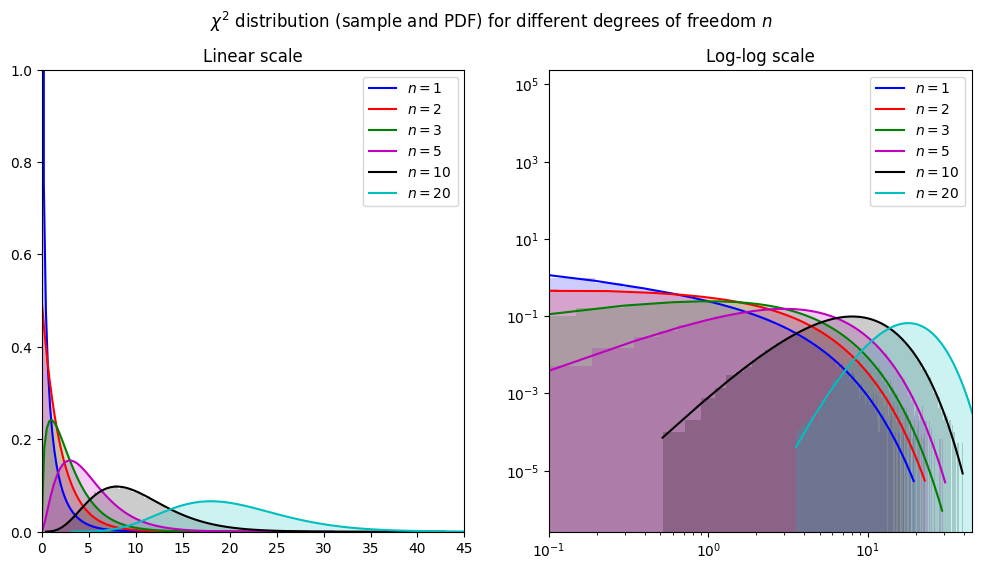

In [5]:

sample_size = 100_000

fig, axes = plt.subplots(ncols=2, figsize=(12, 6))

for ax, is_log_scale in zip(axes, (False, True)):
    for color, n in [
        ("b", 1),
        ("r", 2),
        ("g", 3),
        ("m", 5),
        ("k", 10),
        ("c", 20)
    ]:
        chi2_sample = [np.sum(np.random.normal(size=n) ** 2) for _ in range(sample_size)]
        ax.hist(chi2_sample, bins=200, density=True, alpha=0.2, color=color)
        chi2_range = np.linspace(min(chi2_sample), max(chi2_sample), num=100)
        ax.plot(
            chi2_range,
            np.exp(
                -(n / 2) * np.log(2)
                - scipy.special.loggamma(n / 2)
                + (n / 2 - 1) * np.log(chi2_range)
                - chi2_range / 2
            ),
            color=color,
            label=f"$n = {n}$"
        )

    if is_log_scale:
        ax.set_xscale("log")
        ax.set_xlim(1e-1, 45)
        ax.set_yscale("log")
        ax.set_title("Log-log scale")
    else:
        ax.set_xlim(0, 45)
        ax.set_ylim(0, 1)
        ax.set_title("Linear scale")
    ax.legend()

fig.suptitle("$\chi^2$ distribution (sample and PDF) for different degrees of freedom $n$")
plt.show()

# Bad Gaussian RNG
- take $n = {1, 2, ..., 10}$
- $\forall n$ generate $10^8$ sets of $n$ samples from $U(0, 1)$
- $\forall n$ populate a histogram of sums of the values, getting a sample of $s$
- plot histogram in linear and log scale

In [35]:
import matplotlib
import matplotlib.cm
import matplotlib.colors
import scipy.stats


def plot_central_limit_theorem_convergence(seed_rv: scipy.stats.rv_continuous, n_max: int = 15, sample_size: int = int(1e7)):
    cmap = matplotlib.colormaps["viridis"]
    _, ax = plt.subplots(figsize=(10, 8))

    lower_bound = 0
    upper_bound = 0

    for n in range(1, n_max + 1):
        sample = np.sum(seed_rv.rvs(size=(sample_size, n)), axis=1)
        # move the sample to zero-mean
        sample_unbiased = sample - seed_rv.mean() * n
        # std scales with sqrt(n), so dial it back to the original distribution's standard deviation
        sample_scaled = sample_unbiased / np.sqrt(n)
        lower_bound = min(lower_bound, min(sample_scaled))
        upper_bound = max(upper_bound, max(sample_scaled))
        ax.hist(
            sample_scaled,
            bins=100,
            # alpha=0.2,
            histtype="step",
            linewidth=2,
            density=True,
            color=cmap(int(255 * n / n_max)),
        )

    limit_normal_rv = scipy.stats.norm(loc=0, scale=seed_rv.std())
    x = np.linspace(lower_bound, upper_bound, 300)
    ax.plot(x, limit_normal_rv.pdf(x), color="k", linewidth=0.5)

    plt.colorbar(
        matplotlib.cm.ScalarMappable(
            norm=matplotlib.colors.Normalize(1, n_max),
            cmap=cmap,
        ),
        ax=ax,
        label="Term #",
    )

    plt.show()

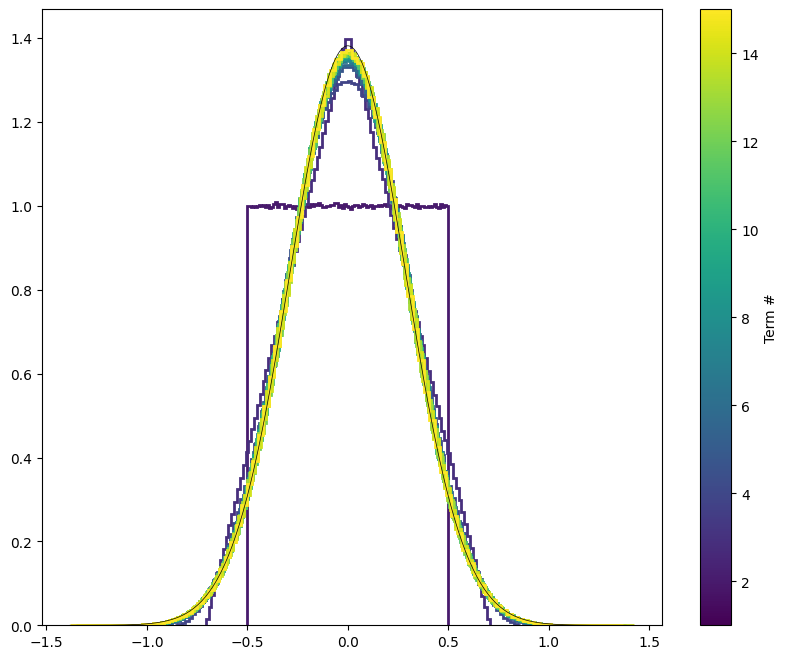

In [36]:
plot_central_limit_theorem_convergence(seed_rv = scipy.stats.uniform(0, 1))

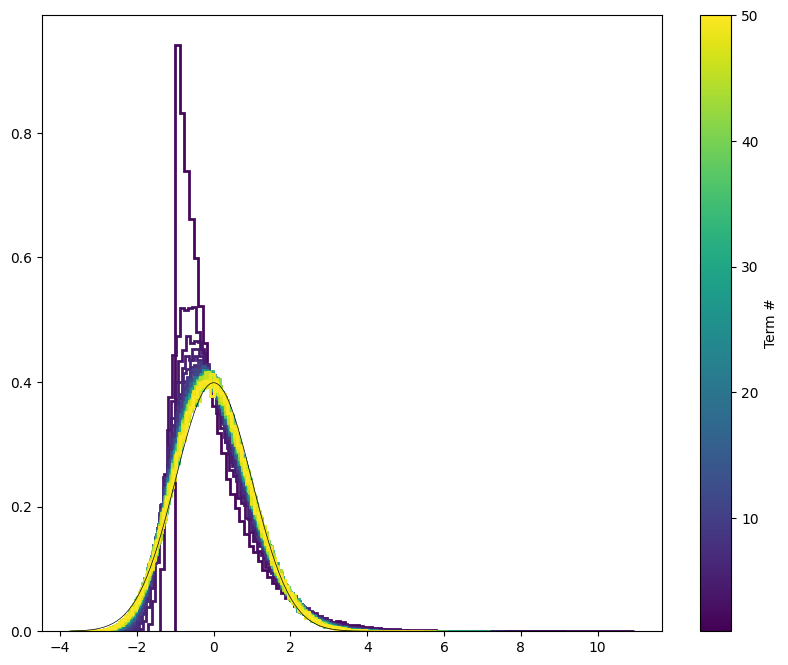

In [37]:

plot_central_limit_theorem_convergence(seed_rv = scipy.stats.expon(), n_max=50, sample_size=int(1e5))

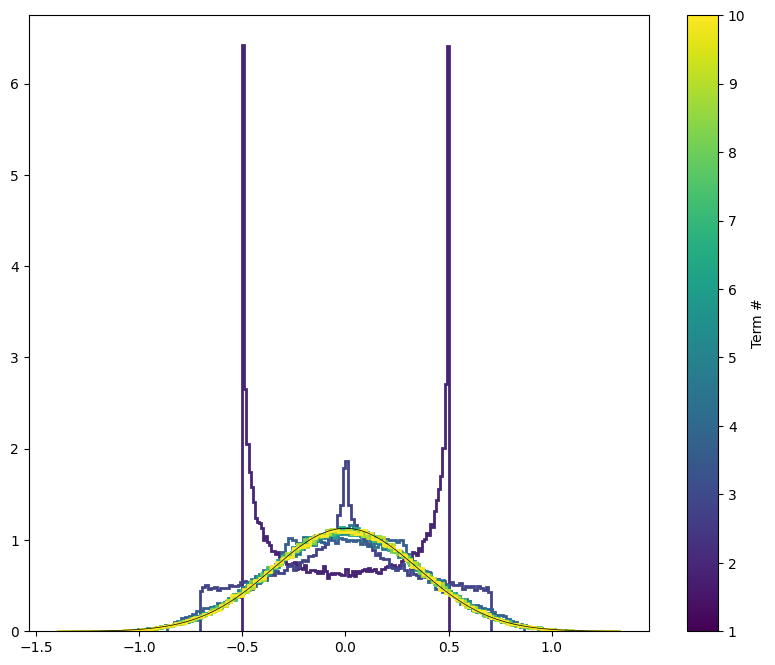

In [39]:
plot_central_limit_theorem_convergence(seed_rv = scipy.stats.arcsine(), n_max=10, sample_size=int(1e5))